Optimal Strategy: [2, 1, 2, 1, 2, 1, 2, 1, 2], Reliability: 0.1434
experiment_4: Fixed Reliability = 0.0029, Optimal Reliability = 0.0084
experiment_5: Fixed Reliability = 0.0029, Optimal Reliability = 0.0063
experiment_6: Fixed Reliability = 0.0029, Optimal Reliability = 0.0077


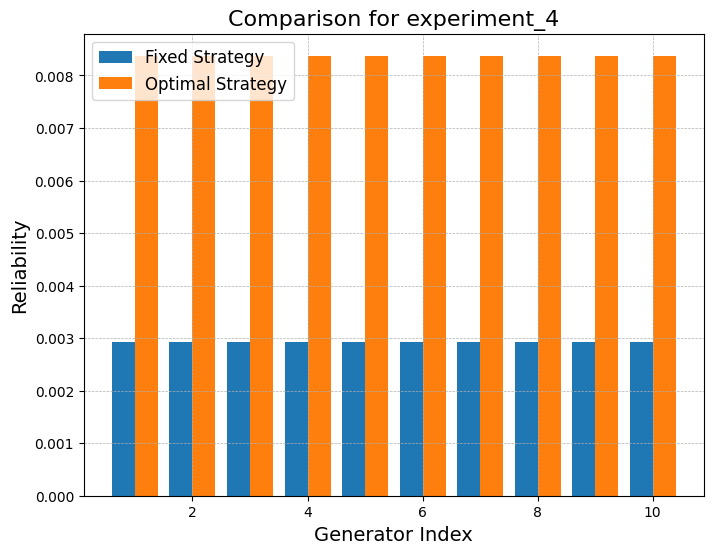

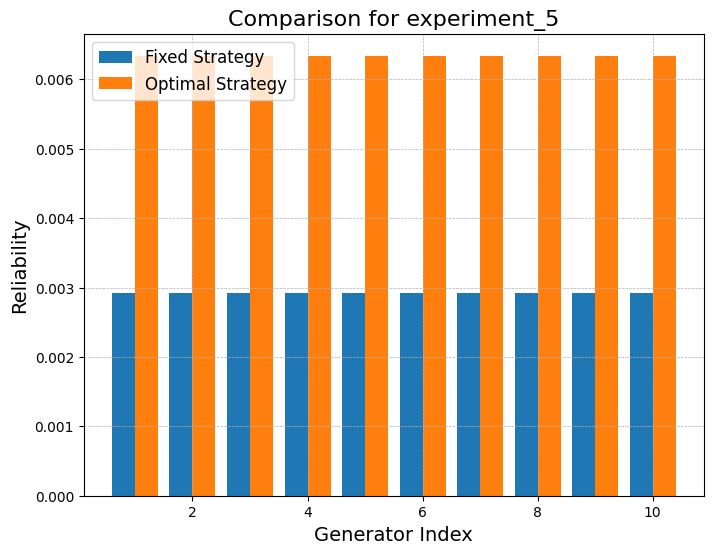

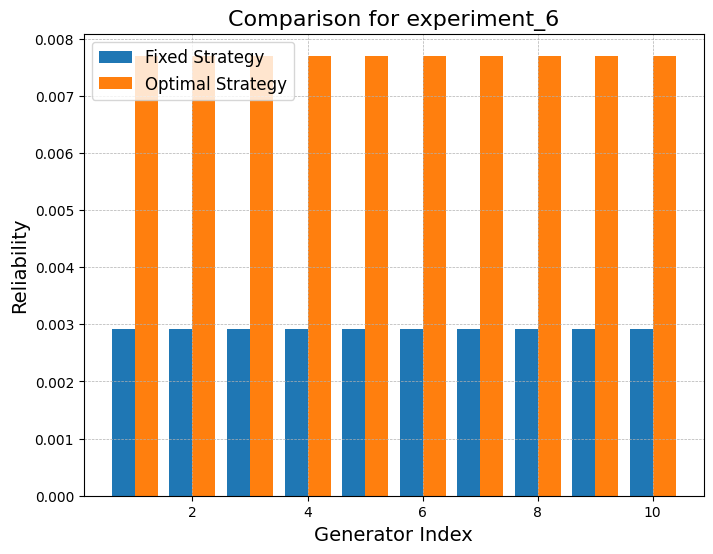

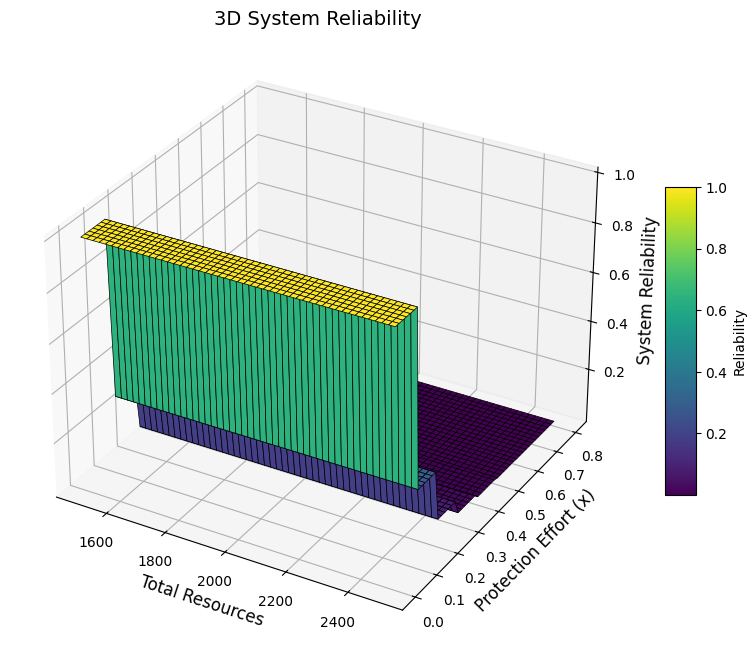

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# داده‌های ژنراتورها از جدول 2
generator_data = [
    {"performance": 0.5, "alpha": 1.2, "baseline_cdf": lambda t: 1 - np.exp(-t / 1000)},
    {"performance": 1.0, "alpha": 1.2, "baseline_cdf": lambda t: 1 - np.exp(-t / 950)},
    {"performance": 1.5, "alpha": 1.1, "baseline_cdf": lambda t: 1 - np.exp(-t / 950)},
    {"performance": 2.0, "alpha": 1.1, "baseline_cdf": lambda t: 1 - np.exp(-t / 900)},
    {"performance": 2.5, "alpha": 1.0, "baseline_cdf": lambda t: 1 - np.exp(-t / 900)},
    {"performance": 3.0, "alpha": 1.0, "baseline_cdf": lambda t: 1 - np.exp(-t / 850)},
    {"performance": 3.5, "alpha": 0.9, "baseline_cdf": lambda t: 1 - np.exp(-t / 800)},
    {"performance": 4.0, "alpha": 0.9, "baseline_cdf": lambda t: 1 - np.exp(-t / 750)},
    {"performance": 4.5, "alpha": 0.8, "baseline_cdf": lambda t: 1 - np.exp(-t / 750)},
]

# داده‌های استراتژی‌های ثابت و بهینه از جدول 5
experiments = {
    "experiment_4": {"fixed": [7, 7, 6, 6, 5, 4, 3, 2, 1], "optimal": [2, 3, 5, 3, 6, 5, 1, 7, 2]},
    "experiment_5": {"fixed": [7, 7, 6, 6, 5, 4, 3, 2, 1], "optimal": [5, 4, 5, 5, 1, 6, 2, 2, 6]},
    "experiment_6": {"fixed": [7, 7, 6, 6, 5, 4, 3, 2, 1], "optimal": [5, 1, 2, 2, 6, 7, 5, 4, 3]},
}


# تابع خرابی داخلی
def internal_failure(generator, T):
    alpha = generator["alpha"]
    baseline_cdf = generator["baseline_cdf"]
    return baseline_cdf(alpha * T)


# قابلیت اطمینان سیستم
def system_reliability(generators, strategy, T=120):
    reliability = 1.0
    for i, allocation in enumerate(strategy):
        gen = generators[i]
        failure_prob = internal_failure(gen, T)
        reliability *= (1 - failure_prob) ** allocation
    return reliability


# الگوریتم ژنتیک برای تخصیص بهینه ژنراتورها
def genetic_algorithm(generators, num_generators, population_size=20, generations=100):
    def fitness(strategy):
        return system_reliability(generators, strategy)

    # مقداردهی اولیه جمعیت
    population = [random.sample(range(1, num_generators + 1), len(generators)) for _ in range(population_size)]
    best_strategy = None
    best_reliability = 0.0

    for gen in range(generations):
        # ارزیابی تناسب
        fitness_scores = [fitness(strategy) for strategy in population]
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        best_strategy = sorted_population[0]
        best_reliability = fitness(best_strategy)

        # تولید نسل جدید
        new_population = sorted_population[:population_size // 2]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(new_population, 2)
            child = parent1[:len(parent1) // 2] + parent2[len(parent2) // 2:]
            new_population.append(child)

        # جهش
        for individual in new_population:
            if random.random() < 0.1:
                idx1, idx2 = random.sample(range(len(individual)), 2)
                individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

        population = new_population

    return best_strategy, best_reliability


# ارزیابی استراتژی‌های ثابت و بهینه
def evaluate_experiments():
    results = {}
    for name, data in experiments.items():
        fixed_strategy = data["fixed"]
        optimal_strategy = data["optimal"]
        fixed_reliability = system_reliability(generator_data, fixed_strategy)
        optimal_reliability = system_reliability(generator_data, optimal_strategy)
        results[name] = (fixed_reliability, optimal_reliability)
        print(f"{name}: Fixed Reliability = {fixed_reliability:.4f}, Optimal Reliability = {optimal_reliability:.4f}")
    return results


# رسم نمودار مقایسه استراتژی‌ها
def plot_comparisons(results):
    for name, (fixed_reliability, optimal_reliability) in results.items():
        x = np.arange(1, 11)
        plt.figure(figsize=(8, 6))
        plt.bar(x - 0.2, [fixed_reliability] * len(x), width=0.4, label="Fixed Strategy")
        plt.bar(x + 0.2, [optimal_reliability] * len(x), width=0.4, label="Optimal Strategy")
        plt.xlabel("Generator Index", fontsize=14)
        plt.ylabel("Reliability", fontsize=14)
        plt.title(f"Comparison for {name}", fontsize=16)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend(fontsize=12)
        plt.show()


# رسم نمودار سه‌بعدی قابلیت اطمینان
def plot_3d_reliability():
    x = np.linspace(0, 0.8, 50)
    total_resources = np.linspace(1500, 2500, 50)

    X, Y = np.meshgrid(x, total_resources)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            strategy = [int(X[i, j] * 10)] * len(generator_data)
            Z[i, j] = system_reliability(generator_data, strategy)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='k', linewidth=0.5)
    ax.set_xlabel("Total Resources", fontsize=12)
    ax.set_ylabel("Protection Effort (x)", fontsize=12)
    ax.set_zlabel("System Reliability", fontsize=12)
    ax.set_title("3D System Reliability", fontsize=14)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Reliability")
    plt.show()


# اجرای برنامه اصلی
if __name__ == "__main__":
    # الگوریتم ژنتیک
    optimal_strategy, optimal_reliability = genetic_algorithm(generator_data, 9)
    print(f"Optimal Strategy: {optimal_strategy}, Reliability: {optimal_reliability:.4f}")

    # ارزیابی قابلیت اطمینان
    results = evaluate_experiments()

    # رسم نمودارهای مقایسه‌ای
    plot_comparisons(results)

    # رسم نمودار سه‌بعدی
    plot_3d_reliability()
